In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

fleet = ['VQ-BGU', 'VQ-BDU']

data = pd.read_csv("VQ-BDU_VQ-BGU_with_delta.csv", parse_dates=['reportts'])


In [2]:
import pandas as pd
from utils import *
from training import *

y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']
features = ['egt', 'tat', 'oat', 'n1a', 'n2a', 'wai', 'nai', 'prv', 'alt', 'mn', 'ff', 'nf']


In [3]:
def correct(data):
  datak = data.copy()
  alpha = 0.5
  alpha_2 = 0.84

  theta = (data['t2'] + 273.16) / (288.16)
  delta = data['p2e'] / 29.92

  datak['nfk'] = data['nf'] / (theta ** alpha)
  datak['n1ak'] = data['n1a'] / (theta ** alpha)
  datak['n1k'] = data['n1'] / (theta ** alpha)
  datak['n2ak'] = data['n2a'] / (theta ** alpha)
  datak['egtk'] = (data['egt'] + 273.16) / (theta ** alpha_2)
  datak['egtk_2'] = (data['egt'] + 273.16) / theta
  datak['ffk'] = (data['ff']) / (delta * (theta ** 0.59))

  datak['egt_peak_k'] = (data['egt_peak'] + 273.16) / (theta ** alpha_2)
  datak['n1a_peak_k'] = data['n1a_peak'] / (theta ** alpha)

  return datak

In [4]:

def predict_num_ensemble(models: List[LinearRegression], X: pd.DataFrame, field: str='alt', bins: List[List[float]]=[]):
  pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])
  for i, [bottom, top] in enumerate(bins):
    index = (X[field] > bottom) & (X[field] <= top)
    pred.loc[index, 'pred'] = models[i].predict(X[index])
  return pred

def filter_split_by_num_field(X: pd.DataFrame, y: pd.DataFrame, field: str, bin: List[float]):
  bottom, top = bin
  index = (X[field] > bottom) & (X[field] <= top)
  return X[index], y[index]

def train_numeric_ensemble_model(X, y, model = 'linreg', field: str='alt', bins: List[List[str]]=[]):
  assert len(X) == len(y)

  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  ensemble = {i: LinearRegression() for i in range(len(bins)) }

  assert len(ensemble) == len(bins)

  for i, bin in enumerate(bins):
    X_train_f, y_train_f = filter_split_by_num_field(X_train, y_train, field, bin)
    ensemble[i].fit(X_train_f, y_train_f)
  
  predicted_train = predict_num_ensemble(ensemble, X_train, field, bins)
  predicted_test = predict_num_ensemble(ensemble, X_test, field, bins)

  return get_metrics(y_test, predicted_test), model, predicted_train, predicted_test, train_i, y_test

In [5]:
features_k = ['egtk', 'tat', 'oat', 'n1ak', 'n2ak', 'wai', 'nai', 'prv', 'alt', 'mn', 'ffk', 'nfk']

bgu = data[data['acnum'] == 'VQ-BGU']
bdu = data[data['acnum'] == 'VQ-BDU']

dataset = build_dataset(
  [correct(bgu), correct(bdu)], 
  y_cols, 
  meta_cols, 
  features_k,
  n_back=20,
)

X = dataset.drop(columns=(meta_cols + y_cols))
y = dataset['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test =  \
  train_numeric_ensemble_model(
    X, y, 'alt', 
    bins=[[0, 3000], [3000, 10_000]]
  )

print(f'Altitude ensemble: {metrics}')

Altitude ensemble: {'rmse': 1.63826, 'mae': 1.33258, 'r2': 0.52378, 'mape': 0.06564}


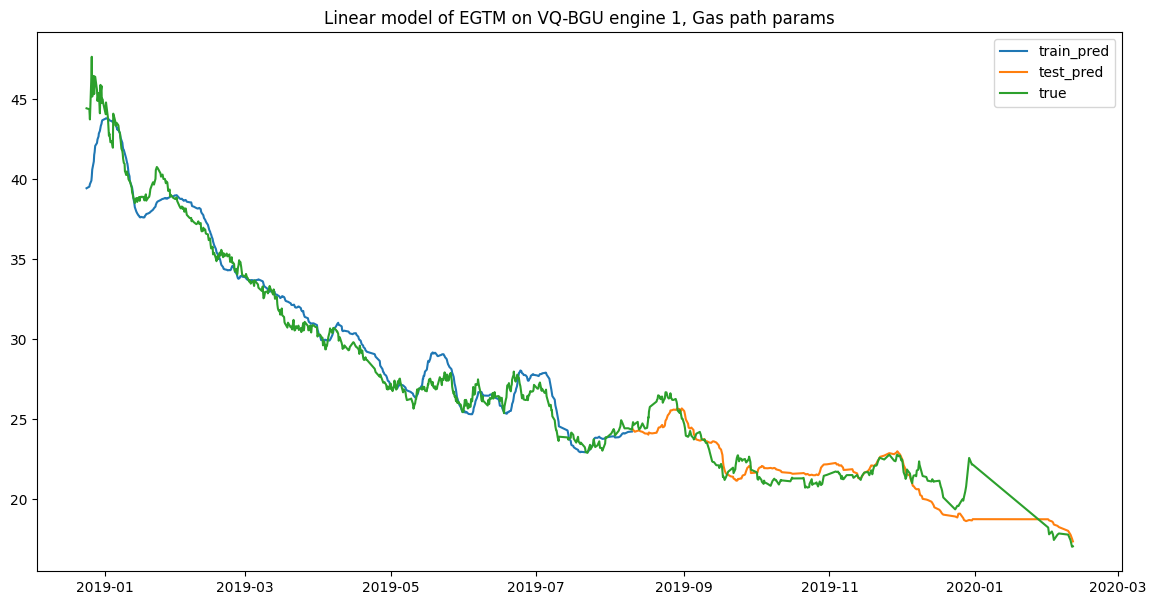

In [6]:
plot_predictions(data, 'VQ-BGU', 1, train_i, predicted_test, predicted_train, is_smooth=True)